**Introdução a Redes Neurais Artificiais com Keras**

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/fabiobento/dnn-course-2025-1/blob/main/nn-intro/10_neural_nets_with_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/fabiobento/dnn-course-2025-1/blob/main/nn-intro/10_neural_nets_with_keras.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Configuração

Este projeto requer Python 3.7 ou superior:

In [1]:
import sys

assert sys.version_info >= (3, 7)

Também requer Scikit-Learn ≥ 1.0.1:

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

E TensorFlow ≥ 2.8:

In [3]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2024-12-12 10:46:52.417801: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 10:46:52.418374: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 10:46:52.420325: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 10:46:52.426463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 10:46:52.438625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

Vamos definir os tamanhos de fonte padrão para melhorar as figuras:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

E vamos criar a pasta `images/ann` (se ela ainda não existir) e definir a função `save_fig()` que é usada nesse notebook para salvar as figuras em alta resolução:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Dos neurônios biológicos aos artificiais
## O Perceptron

In [6]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  #  prevê Verdadeiro e Falso para essas 2 flores

In [7]:
y_pred

array([ True, False])

O `Perceptron` é equivalente a um `SGDClassifier` com `loss=“perceptron”`, sem regularização e com uma taxa de aprendizado constante igual a 1:

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
assert (sgd_clf.coef_ == per_clf.coef_).all()
assert (sgd_clf.intercept_ == per_clf.intercept_).all()

Quando o Perceptron encontra um limite de decisão que separa corretamente as classes, ele interrompe o aprendizado.

Isso significa que o limite de decisão geralmente está muito próximo de uma classe:

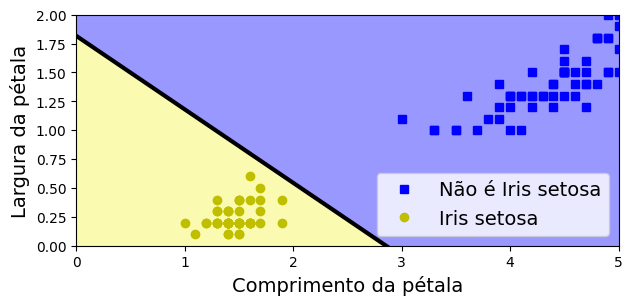

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.figure(figsize=(7, 3))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Não é Iris setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Comprimento da pétala")
plt.ylabel("Largura da pétala")
plt.legend(loc="lower right")
plt.axis(axes)
plt.show()

**Funções de Ativação**

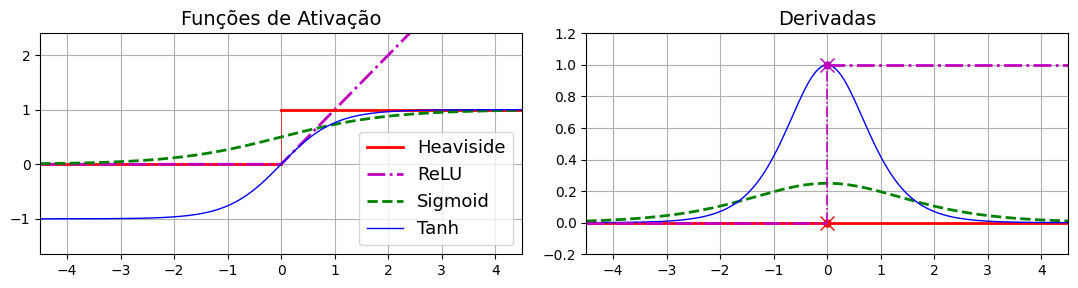

In [10]:
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

plt.figure(figsize=(11, 3.1))

plt.subplot(121)
plt.plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.plot([0, 0], [0, 1], "r-", linewidth=0.5)
plt.plot([0, max_z], [1, 1], "r-", linewidth=2)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
plt.grid(True)
plt.title("Funções de Ativação")
plt.axis([-max_z, max_z, -1.65, 2.4])
plt.gca().set_yticks([-1, 0, 1, 2])
plt.legend(loc="lower right", fontsize=13)

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
plt.plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
plt.plot([0, max_z], [1, 1], "m-.", linewidth=2)
plt.plot([0, 0], [0, 1], "m-.", linewidth=1.2)
plt.plot(0, 1, "mo", markersize=5)
plt.plot(0, 1, "mx", markersize=10)
plt.grid(True)
plt.title("Derivadas")
plt.axis([-max_z, max_z, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

## MLPs para regressão

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_valid)
#rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse = mean_squared_error(y_valid, y_pred) ** 0.5  
# ou
# rmse = np.sqrt(mean_squared_error(y_valid, y_pred))

/home/fabio/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [12]:
rmse

0.5053326657968508

## MLPs de classificação

In [13]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

# Implementação de MLPs com o Keras
## Criando um classificador de imagem usando a API sequencial
### Usando o Keras para carregar o conjunto de dados

Vamos começar carregando o conjunto de dados fashion MNIST.

O Keras tem várias funções para carregar conjuntos de dados populares em `tf.keras.datasets`.

O conjunto de dados já está dividido para você entre um conjunto de treinamento (60.000 imagens) e um conjunto de teste (10.000 imagens), mas pode ser útil dividir ainda mais o conjunto de treinamento para ter um conjunto de validação.

Usaremos 55.000 imagens para treinamento e 5.000 para validação.

In [14]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

O conjunto de treinamento contém **60.000** imagens em escala de cinza, cada uma com **28x28** pixels:

In [15]:
X_train.shape

(55000, 28, 28)

In [16]:
X_valid.shape

(5000, 28, 28)

A intensidade de cada pixel é representada como um byte (0 a 255):

In [17]:
X_train.dtype

dtype('uint8')

Vamos reduzir as intensidades de pixel para o intervalo 0-1 e convertê-las em floats, dividindo-as por 255:

In [18]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

Você pode plotar uma imagem usando a função `imshow()` do Matplotlib, com um mapa de cores `'binary'`:

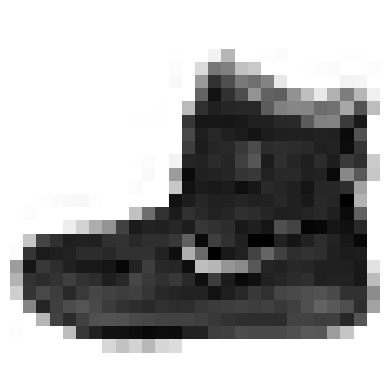

In [19]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Os rótulos são os IDs de classe (representados como uint8), de 0 a 9:

In [20]:
y_train

array([9, 0, 0, ..., 9, 0, 2], dtype=uint8)

Aqui estão os nomes das classes correspondentes:

In [21]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Portanto, a primeira imagem no conjunto de treinamento é uma:

In [22]:
class_names[y_train[0]]

'Ankle boot'

Vamos dar uma olhada em uma amostra das imagens do conjunto de dados:

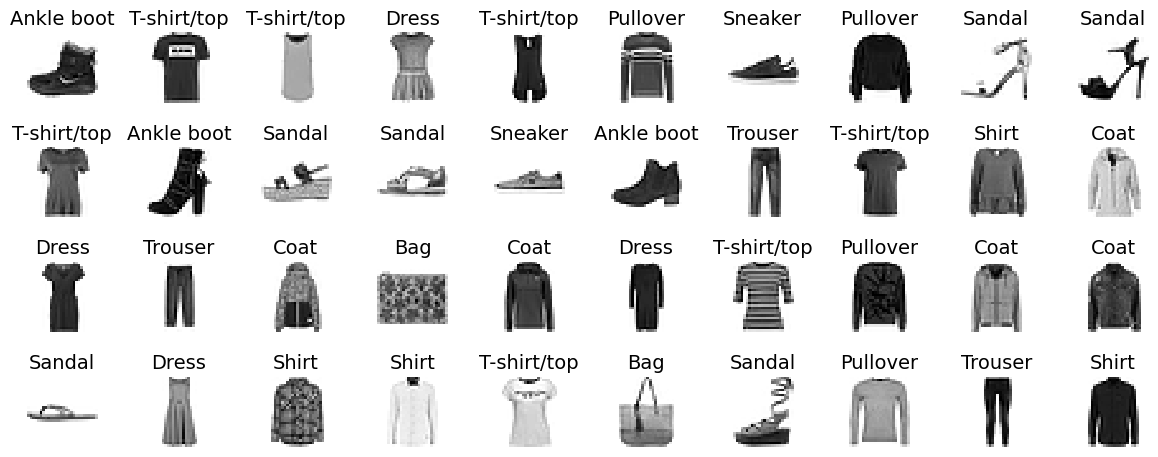

In [23]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

save_fig("fashion_mnist_plot")
plt.show()

### Criando o modelo usando a API sequencial

In [24]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

/home/fabio/anaconda3/envs/homl3/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2024-12-12 10:47:09.735299: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-12 10:47:09.740732: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [25]:
#  código extra - limpar a sessão para redefinir os contadores de nomes
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/home/fabio/anaconda3/envs/homl3/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

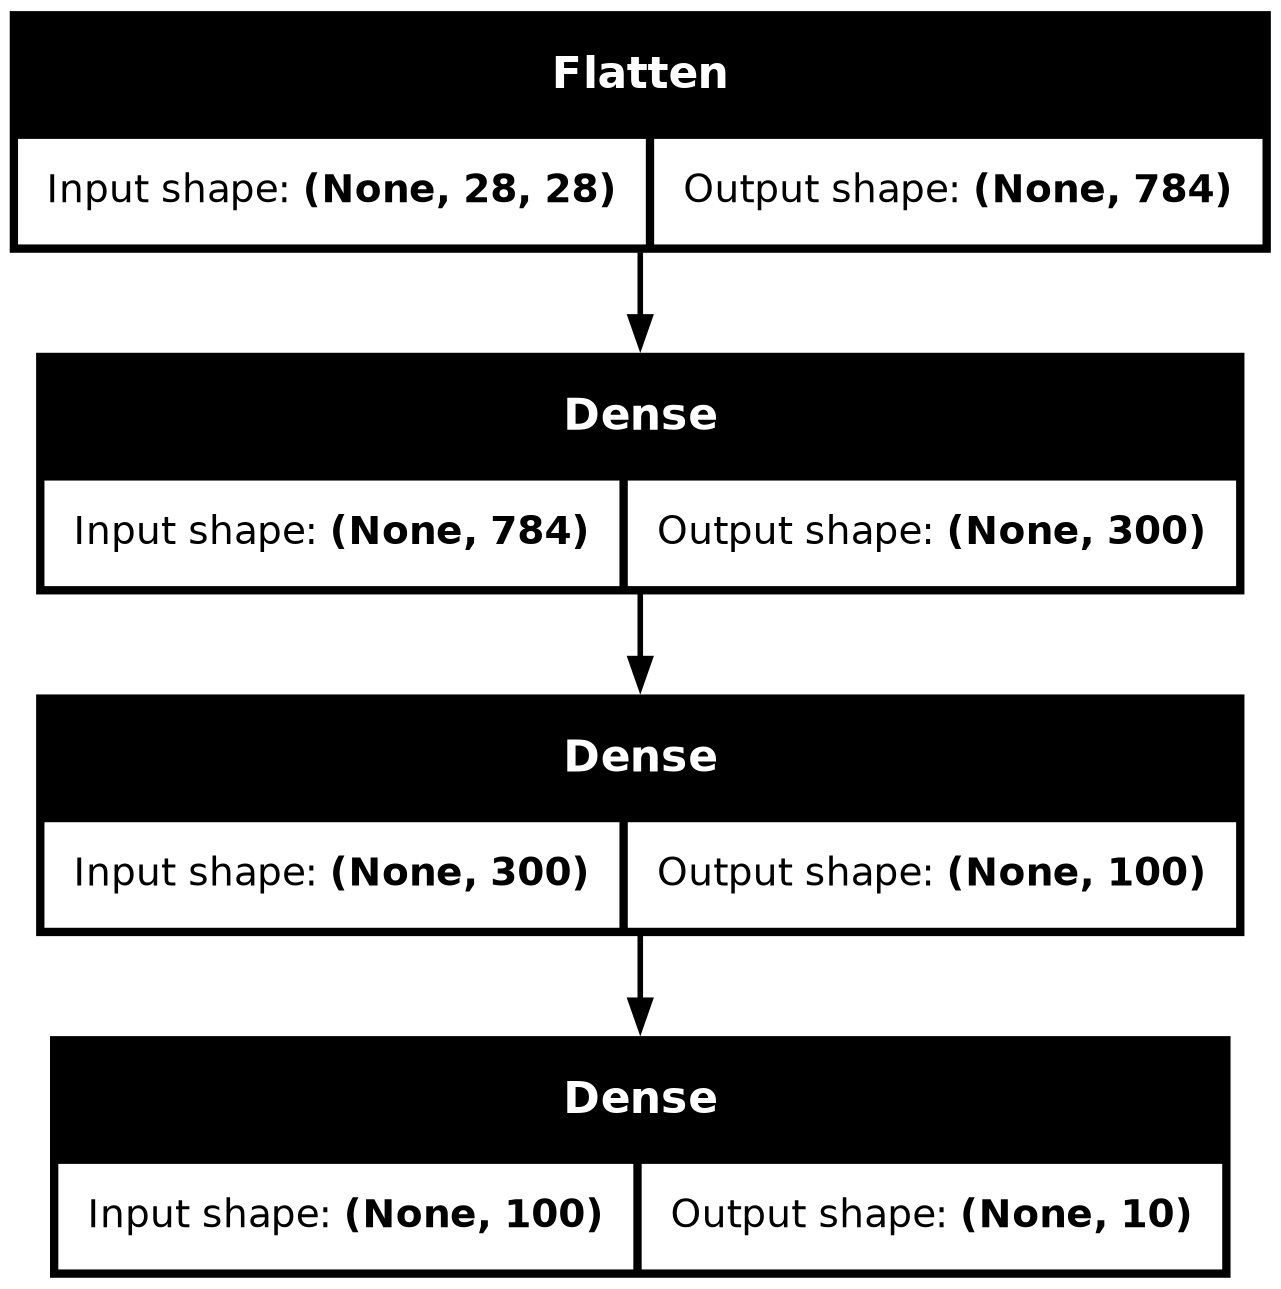

In [27]:
# outra maneira de exibir a arquitetura do modelo
tf.keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [28]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

In [29]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [30]:
model.get_layer('dense') is hidden1

True

In [31]:
weights, biases = hidden1.get_weights()
weights

array([[-0.06747061, -0.05804239, -0.04227825, ...,  0.06755552,
         0.05526657, -0.03560674],
       [-0.00593136, -0.06925413,  0.06079976, ..., -0.039707  ,
         0.04025872, -0.04882924],
       [ 0.01545162, -0.02834662,  0.01288653, ...,  0.05830072,
        -0.01759171,  0.04799785],
       ...,
       [-0.05016356,  0.03276666,  0.00304122, ..., -0.02400881,
        -0.07090075, -0.05680019],
       [-0.03143504, -0.02731362, -0.04132645, ...,  0.06981286,
        -0.05199339, -0.04904463],
       [-0.04222471,  0.02358927, -0.01965236, ...,  0.07076049,
         0.00847953,  0.01706536]], dtype=float32)

In [32]:
weights.shape

(784, 300)

In [33]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [34]:
biases.shape

(300,)

### Compilando o modelo

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

Isso é equivalente a:

In [36]:
# código extra - esta célula é equivalente à célula anterior
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [37]:
# código extra - mostra como converter ids de classe em vetores one-hot
tf.keras.utils.to_categorical([0, 5, 1, 0], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Observação: é importante definir `num_classes` quando o número de classes for maior do que o ID máximo da classe na amostra.

In [38]:
# Código extra - mostra como converter vetores one-hot em IDs de classe
np.argmax(
    [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
     [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
     [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
    axis=1
)

array([0, 5, 1, 0])

### Treinando e avaliando o modelo

In [39]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.9825 - sparse_categorical_accuracy: 0.6942 - val_loss: 0.5042 - val_sparse_categorical_accuracy: 0.8288
Epoch 2/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.5059 - sparse_categorical_accuracy: 0.8267 - val_loss: 0.4540 - val_sparse_categorical_accuracy: 0.8370
Epoch 3/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4512 - sparse_categorical_accuracy: 0.8421 - val_loss: 0.4289 - val_sparse_categorical_accuracy: 0.8450
Epoch 4/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4200 - sparse_categorical_accuracy: 0.8539 - val_loss: 0.4130 - val_sparse_categorical_accuracy: 0.8500
Epoch 5/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3980 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.4006 - val_sparse_categorical_accuracy: 0.8532
Epoch 6/30
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3806 - sparse_categorical_accuracy: 0.8661 - val_loss: 0.3922 - val_sparse_categorical_accuracy:

In [40]:
history.params

{'verbose': 'auto', 'epochs': 30, 'steps': 1719}

In [41]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


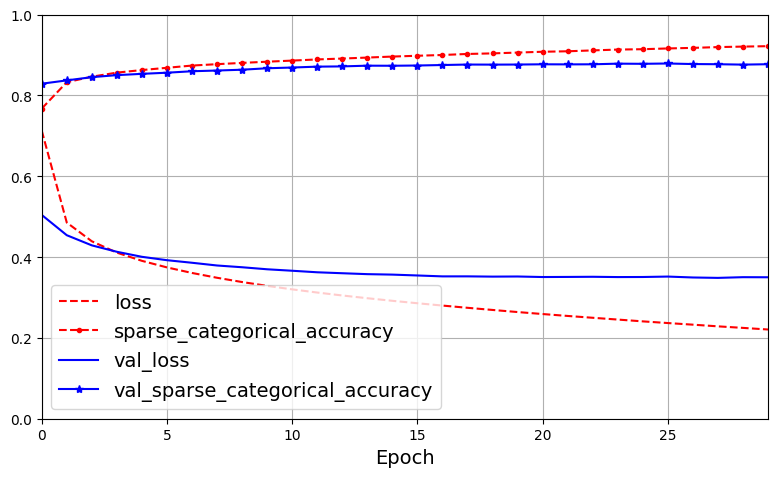

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Época",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # código extra
save_fig("keras_learning_curves_plot")  # código extra
plt.show()

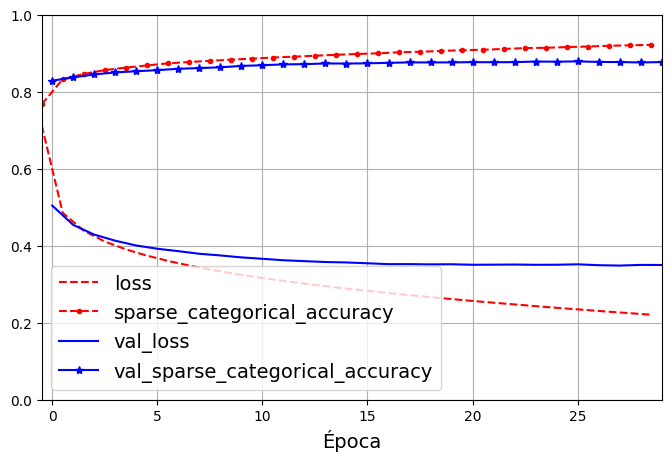

In [43]:
# Código extra - mostra como deslocar a curva de treinamento em -1 a cada 2 épocas
plt.figure(figsize=(8, 5))
for key, style in zip(history.history, ["r--", "r--.", "b-", "b-*"]):
    epochs = np.array(history.epoch) + (0 if key.startswith("val_") else -0.5)
    plt.plot(epochs, history.history[key], style, label=key)
plt.xlabel("Época")
plt.axis([-0.5, 29, 0., 1])
plt.legend(loc="lower left")
plt.grid()
plt.show()

In [44]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 0.3670 - sparse_categorical_accuracy: 0.8754


[0.36415377259254456, 0.8743000030517578]

### Usando o modelo para fazer previsões

In [45]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.02, 0.  , 0.78],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [46]:
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [47]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [48]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

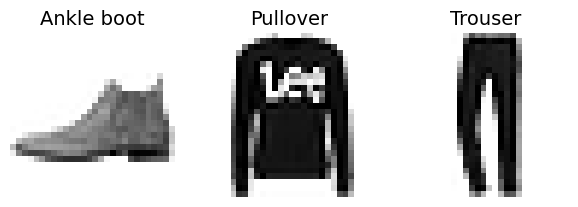

In [49]:
# extra code – this cell generates and saves Figure 10–12
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Criando um MLP de regressão usando a API sequencial

Vamos carregar, dividir e dimensionar o conjunto de dados de moradias da Califórnia:

In [50]:
# Código extra - carregar e dividir o California housing dataset, como anteriormente
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [51]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20


/home/fabio/anaconda3/envs/homl3/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.1839 - loss: 1.4945 - val_RootMeanSquaredError: 0.6994 - val_loss: 0.4891
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - RootMeanSquaredError: 0.6347 - loss: 0.4034 - val_RootMeanSquaredError: 0.6537 - val_loss: 0.4273
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - RootMeanSquaredError: 0.6029 - loss: 0.3639 - val_RootMeanSquaredError: 0.5876 - val_loss: 0.3452
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - RootMeanSquaredError: 0.5878 - loss: 0.3458 - val_RootMeanSquaredError: 0.8298 - val_loss: 0.6886
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - RootMeanSquaredError: 0.5798 - loss: 0.3364 - val_RootMeanSquaredError: 0.8296 - val_loss: 0.6883
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - RootMeanSquaredError: 0.5710 - loss: 0.3261 - val_RootMeanSquaredError: 0.9147 - val_loss: 0.8367
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - RootMeanSquaredError: 0.5641 - lo

In [52]:
rmse_test

0.5317192077636719

In [53]:
y_pred

array([[0.51052034],
       [1.1207864 ],
       [4.832655  ]], dtype=float32)

## Criação de modelos complexos usando a API funcional

Nem todos os modelos de redes neurais são simplesmente sequenciais:
- Alguns podem ter topologias complexas.
- Alguns podem ter várias entradas e/ou várias saídas.

In [54]:
# Código extra - redefine os contadores de nomes e torna o código reproduzível
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [55]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [56]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 8)         │         17 │ input_layer[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 30)        │        270 │ normalization[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30)        │        930 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38)        │          0 │ normalization[0]… │
│ (Concatenate)       │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         39 │ concatenate[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,256 (4.91 KB)

 Trainable params: 1,239 (4.84 KB)

 Non-trainable params: 17 (72.00 B)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

Epoch 1/20


/home/fabio/anaconda3/envs/homl3/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 8))
  warnings.warn(msg)


363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.3507 - loss: 1.9237 - val_RootMeanSquaredError: 0.9720 - val_loss: 0.9447
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - RootMeanSquaredError: 0.6954 - loss: 0.4851 - val_RootMeanSquaredError: 0.6185 - val_loss: 0.3826
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - RootMeanSquaredError: 0.6441 - loss: 0.4153 - val_RootMeanSquaredError: 0.5995 - val_loss: 0.3594
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - RootMeanSquaredError: 0.6255 - loss: 0.3915 - val_RootMeanSquaredError: 0.5856 - val_loss: 0.3429
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - RootMeanSquaredError: 0.6142 - loss: 0.3774 - val_RootMeanSquaredError: 0.6777 - val_loss: 0.4593
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - RootMeanSquaredError: 0.6059 - loss: 0.3673 - val_RootMeanSquaredError: 0.5870 - val_loss: 0.3445
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - RootMeanSquaredError: 0.6009 - lo

/home/fabio/anaconda3/envs/homl3/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(3, 8))
  warnings.warn(msg)


E se você quiser enviar diferentes subconjuntos de recursos de entrada por meio dos caminhos largo ou profundo?

Enviaremos 5 recursos (recursos 0 a 4) e 6 pelo caminho profundo (recursos 2 a 7).

Observe que 3 recursos passarão por ambos (recursos 2, 3 e 4).

In [58]:
tf.random.set_seed(42)  # código extra

In [59]:
input_wide = tf.keras.layers.Input(shape=[5])  # recursos 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # recursos 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [60]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.6268 - loss: 2.7647 - val_RootMeanSquaredError: 0.9963 - val_loss: 0.9927
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.7926 - loss: 0.6288 - val_RootMeanSquaredError: 0.7113 - val_loss: 0.5060
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.7153 - loss: 0.5119 - val_RootMeanSquaredError: 0.6665 - val_loss: 0.4442
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - RootMeanSquaredError: 0.6678 - loss: 0.4462 - val_RootMeanSquaredError: 0.6329 - val_loss: 0.4006
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - RootMeanSquaredError: 0.6386 - loss: 0.4080 - val_RootMeanSquaredError: 0.7853 - val_loss: 0.6166
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - RootMeanSquaredError: 0.6223 - loss: 0.3875 - val_RootMeanSquaredError: 0.9613 - val_loss: 0.9241
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - RootMeanSquaredError: 0.61

Adição de uma saída auxiliar para regularização:

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [62]:
input_wide = tf.keras.layers.Input(shape=[5])  # features 0 to 4
input_deep = tf.keras.layers.Input(shape=[6])  # features 2 to 7
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1, name="main_output")(concat)
aux_output = tf.keras.layers.Dense(1, name="aux_output")(hidden2)
model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [65]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError","RootMeanSquaredError"])

In [66]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - aux_output_RootMeanSquaredError: 1.7253 - aux_output_loss: 3.0614 - loss: 2.7018 - main_output_RootMeanSquaredError: 1.5905 - main_output_loss: 2.6619 - val_aux_output_RootMeanSquaredError: 0.9134 - val_aux_output_loss: 0.8341 - val_loss: 0.5514 - val_main_output_RootMeanSquaredError: 0.7210 - val_main_output_loss: 0.5198
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - aux_output_RootMeanSquaredError: 0.8685 - aux_output_loss: 0.7555 - loss: 0.5376 - main_output_RootMeanSquaredError: 0.7161 - main_output_loss: 0.5134 - val_aux_output_RootMeanSquaredError: 0.8047 - val_aux_output_loss: 0.6474 - val_loss: 0.5122 - val_main_output_RootMeanSquaredError: 0.7051 - val_main_output_loss: 0.4970
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - aux_output_RootMeanSquaredError: 0.7749 - aux_output_loss: 0.6007 - loss: 0.4652 - main_output_RootMeanSquaredError: 0.6707 - main_output_loss: 0.4502 - val_aux_output_RootMeanSquaredError

In [67]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))

# Desempacotando os valores retornados
weighted_sum_of_losses = eval_results[0]  # Perda total ponderada
main_loss = eval_results[1]  # Perda principal
aux_loss = eval_results[2]  # Perda auxiliar

# As métricas começam a partir do índice 3
main_rmse = eval_results[3]  # RMSE da saída principal
aux_rmse = eval_results[4]  # RMSE da saída auxiliar

print(f"Perda ponderada: {weighted_sum_of_losses}")
print(f"Perda principal: {main_loss}, Main RMSE: {main_rmse}")
print(f"Perda auxiliar: {aux_loss}, Aux RMSE: {aux_rmse}")


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - aux_output_RootMeanSquaredError: 0.6290 - aux_output_loss: 0.3957 - loss: 0.3376 - main_output_RootMeanSquaredError: 0.5754 - main_output_loss: 0.3311
Perda ponderada: 0.33691203594207764
Perda principal: 0.32916542887687683, Main RMSE: 0.635313093662262
Perda auxiliar: 0.40372636914253235, Aux RMSE: 0.5740206837654114


In [68]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [69]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


## Usando a API de subclasses para criar modelos dinâmicos

In [74]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # necessário para dar suporte à nomeação do modelo
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

tf.random.set_seed(42)  # Código extra - apenas para reprodutibilidade
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

Aviso: em versões recentes, o Keras exige uma métrica por saída, por isso substituí metrics=[“RootMeanSquaredError”] por metrics=[“RootMeanSquaredError”, “RootMeanSquaredError”] no código abaixo.

In [76]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss=("mse", "mse"), loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError","RootMeanSquaredError"])
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.8028 - RootMeanSquaredError_1: 1.9891 - loss: 3.4347 - mse_loss: 4.0758 - val_RootMeanSquaredError: 1.1818 - val_RootMeanSquaredError_1: 1.0717 - val_loss: 1.3718 - val_mse_loss: 1.1483
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - RootMeanSquaredError: 0.8493 - RootMeanSquaredError_1: 0.8913 - loss: 0.7296 - mse_loss: 0.7958 - val_RootMeanSquaredError: 0.8131 - val_RootMeanSquaredError_1: 0.7681 - val_loss: 0.6540 - val_mse_loss: 0.5899
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.7455 - RootMeanSquaredError_1: 0.7770 - loss: 0.5609 - mse_loss: 0.6040 - val_RootMeanSquaredError: 0.7163 - val_RootMeanSquaredError_1: 0.7416 - val_loss: 0.5168 - val_mse_loss: 0.5498
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - RootMeanSquaredError: 0.6947 - RootMeanSquaredError_1: 0.7399 - loss: 0.4894 - mse_loss: 0.5476 - val_RootMeanSquaredError: 0.6609 - val_RootMeanSquar

## Salvando e restaurando um modelo

**Aviso**: O Keras agora recomenda o uso do formato `.keras` para salvar modelos e o formato `h5` para pesos. Portanto, atualizei o código nesta seção para mostrar primeiro o que precisa ser alterado se ainda quiser usar o formato `SavedModel` do TensorFlow e, em seguida, como usar os formatos recomendados.

In [77]:
# código extra - exclui o diretório, caso ele já exista

import shutil

shutil.rmtree("my_keras_model", ignore_errors=True)

**Aviso**: O método `model.save()` do Keras não é mais compatível com o formato `SavedModel` do TensorFlow. No entanto, você ainda pode exportar modelos para o formato `SavedModel` usando `model.export()` desta forma:

In [78]:
model.export("my_keras_model")

INFO:tensorflow:Assets written to: my_keras_model/assets


INFO:tensorflow:Assets written to: my_keras_model/assets


Saved artifact at 'my_keras_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): Tuple[TensorSpec(shape=(None, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)]
Output Type:
  Tuple[TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)]
Captures:
  133489373714160: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  133487553493680: TensorSpec(shape=(1, 5), dtype=tf.float32, name=None)
  133487553493856: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  133487553494384: TensorSpec(shape=(1, 6), dtype=tf.float32, name=None)
  133487574578128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133487553883200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133487553880560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133487553884256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133487553877568: TensorSpec(shape=

In [79]:
# Código extra - mostra o conteúdo do diretório my_keras_model/
for path in sorted(Path("my_keras_model").glob("**/*")):
    print(path)

my_keras_model/assets
my_keras_model/fingerprint.pb
my_keras_model/saved_model.pb
my_keras_model/variables
my_keras_model/variables/variables.data-00000-of-00001
my_keras_model/variables/variables.index


**Aviso**: No Keras 3, não é mais possível carregar um `SavedModel` do TensorFlow como um modelo do Keras. No entanto, você pode carregar um `SavedModel` como uma camada `tf.keras.layers.TFSMLayer`, mas esteja ciente de que essa camada só pode ser usada para inferência: nenhum treinamento.

In [80]:
tfsm_layer = tf.keras.layers.TFSMLayer("my_keras_model")
y_pred_main, y_pred_aux = tfsm_layer((X_new_wide, X_new_deep))

**Aviso**: O Keras agora exige que os pesos salvos tenham a extensão `.weights.h5`. Eles não são mais salvos usando o formato `SavedModel`.

In [81]:
model.save_weights("my_weights.weights.h5")

In [82]:
model.load_weights("my_weights.weights.h5")

Para salvar um modelo usando o formato `.keras`, basta usar `model.save()`:

In [83]:
model.save("my_model.keras")

Para carregar um modelo `.keras`, use a função `tf.keras.models.load_model()`. Se o modelo usar algum objeto personalizado, você deverá passá-lo para a função por meio do argumento `custom_objects`:

In [84]:
loaded_model = tf.keras.models.load_model(
    "my_model.keras",
    custom_objects={"WideAndDeepModel": WideAndDeepModel}
)

## Usando _Callbacks_

In [85]:
shutil.rmtree("my_checkpoints", ignore_errors=True)  # código extra

**Aviso**: conforme explicado anteriormente, o Keras agora exige que os arquivos de _checkpoint_(ponto de verificação) tenham uma extensão `.weights.h5`:

In [86]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5922 - RootMeanSquaredError_1: 0.6441 - loss: 0.3572 - mse_loss: 0.4149 - val_RootMeanSquaredError: 0.6029 - val_RootMeanSquaredError_1: 0.6284 - val_loss: 0.3666 - val_mse_loss: 0.3948
Epoch 2/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5861 - RootMeanSquaredError_1: 0.6371 - loss: 0.3498 - mse_loss: 0.4059 - val_RootMeanSquaredError: 0.6418 - val_RootMeanSquaredError_1: 0.7508 - val_loss: 0.4271 - val_mse_loss: 0.5635
Epoch 3/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5829 - RootMeanSquaredError_1: 0.6330 - loss: 0.3459 - mse_loss: 0.4008 - val_RootMeanSquaredError: 0.5621 - val_RootMeanSquaredError_1: 0.6432 - val_loss: 0.3257 - val_mse_loss: 0.4137
Epoch 4/10
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5802 - RootMeanSquaredError_1: 0.6300 - loss: 0.3428 - mse_loss: 0.3970 - val_RootMeanSquaredError: 0.6299 - val_RootMeanSquaredEr

In [87]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 0.5745 - RootMeanSquaredError_1: 0.6193 - loss: 0.3355 - mse_loss: 0.3836 - val_RootMeanSquaredError: 1.0601 - val_RootMeanSquaredError_1: 0.9696 - val_loss: 1.1054 - val_mse_loss: 0.9399
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5699 - RootMeanSquaredError_1: 0.6152 - loss: 0.3303 - mse_loss: 0.3786 - val_RootMeanSquaredError: 1.0734 - val_RootMeanSquaredError_1: 1.0606 - val_loss: 1.1495 - val_mse_loss: 1.1243
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5677 - RootMeanSquaredError_1: 0.6133 - loss: 0.3277 - mse_loss: 0.3762 - val_RootMeanSquaredError: 0.7340 - val_RootMeanSquaredError_1: 0.6395 - val_loss: 0.5258 - val_mse_loss: 0.4089
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.5649 - RootMeanSquaredError_1: 0.6093 - loss: 0.3244 - mse_loss: 0.3713 - val_RootMeanSquaredError: 0.8468 - val_RootMeanSquar

In [88]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")

In [89]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)

Epoch=0, val/train=2.01
Epoch=1, val/train=1.67
Epoch=2, val/train=3.31
Epoch=3, val/train=1.90
Epoch=4, val/train=4.71
Epoch=5, val/train=2.38
Epoch=6, val/train=3.73
Epoch=7, val/train=1.35
Epoch=8, val/train=2.36
Epoch=9, val/train=1.20


## Usando o TensorBoard para visualização

O TensorBoard vem pré-instalado no Colab, mas não o `tensorboard-plugin-profile`, portanto, vamos instalá-lo:

In [90]:
if "google.colab" in sys.modules:  # extra code
    %pip install -q -U tensorboard-plugin-profile

In [91]:
shutil.rmtree("my_logs", ignore_errors=True)

In [92]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [93]:
# Código extra - criar o primeiro modelo de regressão que usamos anteriormente
tf.keras.backend.clear_session()
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

/home/fabio/anaconda3/envs/homl3/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [94]:
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

Epoch 1/20


2024-12-12 10:55:57.291443: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-12-12 10:55:57.291466: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-12-12 10:55:57.291574: I external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1239] Profiler found 1 GPUs
2024-12-12 10:55:57.291745: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:137] cuptiGetTimestamp: error 999: 
2024-12-12 10:55:57.291752: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-12-12 10:55:57.291755: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-12-12 10:55:57.291758: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with

283/363 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - RootMeanSquaredError: 1.6542 - loss: 2.7992

2024-12-12 10:55:57.634278: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2024-12-12 10:55:57.634302: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2024-12-12 10:55:57.634313: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:135] cuptiGetTimestamp: ignored due to a previous error.
2024-12-12 10:55:57.634317: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:186] cuptiSubscribe: ignored due to a previous error.
2024-12-12 10:55:57.634320: E external/local_xla/xla/backends/profiler/gpu/cupti_error_manager.cc:223] cuptiGetResultString: ignored due to a previous error.
2024-12-12 10:55:57.634323: E external/local_xla/xla/backends/profiler/gpu/cupti_tracer.cc:1282] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error 
2024-12-12 10:55:57.719337: I external/local_tsl/tsl/profiler/lib/profiler_session.cc:70] 

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 1.5778 - loss: 2.5591 - val_RootMeanSquaredError: 1.0257 - val_loss: 1.0521
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.8794 - loss: 0.7742 - val_RootMeanSquaredError: 0.8088 - val_loss: 0.6541
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - RootMeanSquaredError: 0.8211 - loss: 0.6750 - val_RootMeanSquaredError: 0.7685 - val_loss: 0.5906
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 0.7885 - loss: 0.6225 - val_RootMeanSquaredError: 0.7458 - val_loss: 0.5562
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - RootMeanSquaredError: 0.7631 - loss: 0.5829 - val_RootMeanSquaredError: 0.7227 - val_loss: 0.5223
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - RootMeanSquaredError: 0.7412 - loss: 0.5500 - val_RootMeanSquaredError: 0.7006 - val_loss: 0.4909
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - RootMeanSquaredError: 0.7229 - loss: 

In [95]:
print("my_logs")
for path in sorted(Path("my_logs").glob("**/*")):
    print("  " * (len(path.parts) - 1) + path.parts[-1])

my_logs
  run_2024_12_12_10_55_57
    train
      events.out.tfevents.1734011757.desktop.76932.0.v2
      plugins
        profile
          2024_12_12_10_55_57
            desktop.xplane.pb
    validation
      events.out.tfevents.1734011757.desktop.76932.1.v2


Vamos carregar a extensão Jupyter `tensorboard` e iniciar o servidor TensorBoard: 

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs

**Nota**: se preferir acessar o TensorBoard em uma guia separada, clique no link “localhost:6006” abaixo:

In [97]:
# código extra

if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

Você também pode visualizar histogramas, imagens, textos e até mesmo ouvir áudio usando o TensorBoard:

In [98]:
test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # fica maior
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # fica mais brilhante
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

2024-12-12 10:56:08.298203: E tensorflow/core/util/util.cc:131] oneDNN supports DT_STRING only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


**Nota**: costumava ser possível compartilhar facilmente seus registros do TensorBoard com o mundo, carregando-os em https://tensorboard.dev/. Infelizmente, esse serviço será encerrado em dezembro de 2023, portanto, removi os exemplos de código correspondentes deste notebook.

Quando você interromper esse kernel do Jupyter (também conhecido como Runtime), ele também interromperá automaticamente o servidor do TensorBoard. Outra maneira de interromper o servidor do TensorBoard é eliminá-lo, se estiver executando no Linux ou no MacOSX. Primeiro, você precisa encontrar o ID do processo:

In [99]:
# Código extra - lista todas as instâncias do servidor TensorBoard em execução

from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:00:07 ago; pid 94334)


Em seguida, você pode usar o seguinte comando no Linux ou MacOSX, substituindo `<pid>` pelo pid listado acima:

    !kill <pid>

No Windows:

    !taskkill /F /PID <pid>

# Ajuste fino dos hiperparâmetros da rede neural

Nesta seção, usaremos novamente o conjunto de dados Fashion MNIST:

In [100]:
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [101]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [102]:
if "google.colab" in sys.modules:
    %pip install -q -U keras_tuner~=1.4.6

In [103]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [104]:
random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)
random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 19s]
val_accuracy: 0.8352000117301941

Best val_accuracy So Far: 0.8618000149726868
Total elapsed time: 00h 01m 37s


In [105]:
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [106]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values  # melhores valores de hiperparâmetro

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [107]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8618000149726868


In [108]:
best_trial.metrics.get_last_value("val_accuracy")

0.8618000149726868

In [109]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8764 - loss: 0.3317
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8833 - loss: 0.3183
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8858 - loss: 0.3083
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8912 - loss: 0.2980
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8926 - loss: 0.2900
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8951 - loss: 0.2829
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8968 - loss: 0.2762
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8998 - loss: 0.2706
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step - accuracy: 0.9016 - loss: 0.2641
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 939us/step - accuracy: 0.9036 - loss: 0.2582
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.8526 - loss: 0.4318


In [110]:
class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [111]:
hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [112]:
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 23s]
val_accuracy: 0.8406000137329102

Best val_accuracy So Far: 0.8659999966621399
Total elapsed time: 00h 10m 23s


In [113]:
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 18s]
val_accuracy: 0.8375999927520752

Best val_accuracy So Far: 0.8551999926567078
Total elapsed time: 00h 03m 18s


In [ ]:
%tensorboard --logdir {root_logdir}

# Exercícios

## 1. O [_TensorFlow playground_](https://playground.tensorflow.org/)  é um prático simulador de rede neural criado pela equipe do TensorFlow. Neste exercício, você treinará vários classificadores binários em apenas alguns cliques e ajustará a arquitetura do modelo e seus hiperparâmetros para obter alguma intuição sobre como as redes neurais funcionam e o que seus hiperparâmetros fazem. Reserve algum tempo para explorar o seguinte:
### 1.a) **Os padrões aprendidos por uma rede neural**. Tente treinar a rede neural padrão clicando no botão __Run__ (canto superior esquerdo). Observe como ela encontra rapidamente uma boa solução para a tarefa de classificação. Os neurônios da primeira camada oculta aprenderam padrões simples, enquanto os neurônios da segunda camada oculta aprenderam a combinar os padrões simples da primeira camada oculta em padrões mais complexos. Em geral, quanto mais camadas houver, mais complexos poderão ser os padrões.
### 1.b) **Funções de ativação**. Tente substituir a função de ativação tanh por uma função de ativação ReLU e treine a rede novamente. Observe que ela encontra uma solução ainda mais rapidamente, mas, desta vez, os limites são lineares. Isso se deve à forma da função ReLU
### 1.c) **O risco de mínimos locais**. Modifique a arquitetura da rede para ter apenas uma camada oculta com três neurônios. Treine-a várias vezes (para redefinir os pesos da rede, clique no botão __Reset__ ao lado do botão __Run__). Observe que o tempo de treinamento varia muito e, às vezes, ele até fica preso em um mínimo local.
### 1.d) **O que acontece quando as redes neurais são muito pequenas**. Remova um neurônio para manter apenas dois. Observe que a rede neural agora é incapaz de encontrar uma boa solução, mesmo que você tente várias vezes. O modelo tem poucos parâmetros e sistematicamente não se ajusta ao conjunto de treinamento.
### 1.e) **O risco de __vanishing gradients__ em redes profundas**. Selecione o conjunto de dados __Spiral__ (o conjunto de dados no canto inferior direito em _DATA_) e altere a arquitetura da rede para ter quatro camadas ocultas com oito neurônios cada. Observe que o treinamento é muito mais demorado e frequentemente fica preso em platôs por longos períodos de tempo. Observe também que os neurônios das camadas mais altas (à direita) tendem a evoluir mais rapidamente do que os neurônios das camadas mais baixas (à esquerda). Esse problema, chamado de __vanishing gradients__, pode ser atenuado com uma melhor inicialização dos pesos e outras técnicas, melhores otimizadores (como _AdaGrad_ ou _Adam_) ou normalização de lotes (discutido no tópico 11-Treinando Redes Neurais Profundas).
### 1.f) **Vá além**. Reserve cerca de uma hora para brincar com outros parâmetros e ter uma noção do que eles fazem, a fim de desenvolver uma compreensão intuitiva das redes neurais.


## 2. Desenhe uma RNA usando os neurônios artificiais originais (como os da Figura 10-3) que calcula $A \bigoplus B$ (onde $\bigoplus B$ representa a operação XOR). Dica: $A \bigoplus B = (A \wedge\neg B)  \vee (\neg A \wedge B)$


## 3. Por que geralmente é preferível usar um classificador de regressão logística em vez de um perceptron clássico (ou seja, uma única camada de unidades lógicas de limiar treinadas usando o algoritmo de treinamento do perceptron)? Como você pode ajustar um perceptron para torná-lo equivalente a um classificador de regressão logística?

## 4. Por que a função de ativação sigmoide foi um fundamental no treinamento das primeiros MLPs?

## 5. Cite três funções de ativação populares. Você consegue desenhá-las?

## 6. Suponha que você tenha uma MLP composta de uma camada de entrada com 10 neurônios, seguida de uma camada oculta com 50 neurônios e, finalmente, uma camada de saída com 3 neurônios. Todos os neurônios usam a função de ativação ReLU.
### 6.a) Qual é o formato da matriz de entrada $\mathbf{X}$?
### 6.b) Qual é a forma da matriz de peso $\mathbf{W}_{h}$ e do vetor de __bias__ $\mathbf{b}_{h}$ da camada oculta?
### 6.c) Quais são as formas da matriz de peso $W_{o}$ e do vetor de __bias__ $\mathbf{b}_{o}$ da camada de saída?
### 6.d) Qual é a forma da matriz de saída  da rede $\mathbf{Y}$?
### 6.e) Escreva a equação que calcula a matriz de saída da rede $\mathbf{Y}$ como uma função de $\mathbf{X}$, $\mathbf{W}_{h}$, $\mathbf{b}_{h}$, $W_{o}$ e $\mathbf{b}_{o}$.

## 7. De quantos neurônios você precisa na camada de saída se quiser classificar os e-mails em spam ou ham? Que função de ativação você deve usar na camada de saída? Se, em vez disso, quiser lidar com o MNIST, quantos neurônios são necessários na camada de saída e qual função de ativação deve ser usada? E para fazer com que sua rede preveja os preços de imóveis?

## 8. O que é _backpropagation_ e como ele funciona? Qual é a diferença entre _backpropagation_ e _reverse-mode autodiff_?

## 9. Você pode listar todos os hiperparâmetros que podem ser ajustados em um MLP básico? Se o MLP se ajustar demais aos dados de treinamento, como você poderia ajustar esses hiperparâmetros para tentar resolver o problema?

## 10. Treine uma DNN no conjunto de dados MNIST (você pode carregá-lo usando `tf.keras.datasets.mnist.load_data()`). Veja se você consegue obter mais de 98% de precisão ajustando manualmente os hiperparâmetros. Tente procurar a taxa de aprendizado ideal usando a abordagem apresentada neste tópico (ou seja, aumentando a taxa de aprendizado exponencialmente, traçando o gráfico da perda e encontrando o ponto em que a perda aumenta). Em seguida, tente ajustar os hiperparâmetros usando o Keras Tuner com todos os recursos - salvar pontos de verificação, usar parada antecipada e traçar curvas de aprendizado usando o TensorBoard. 